In [14]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils
import const
infor = const.infor
forma_names = const.forma_names
main_path = const.main_path
raw_tess_path = const.raw_tess_path
tess_metad_path = const.tess_metad_path
xom_data_path = const.xom_data_path

### GPU Setup

In [2]:
# Specific GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0:2], 'GPU')
mirro_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


### Data Preprocessing

In [3]:
###      DOUBLE CHECK      ###
detec_type = 'plane_moon_cut_injec'

In [4]:
# Find the most recent file in injec_curve
# datas = utils.retur_most_recen(f'{xom_data_path}padde_cuts/')
datas = 'padde_cuts-34925-1370-8598.pkl'
print(f'File: {datas}')

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

File: padde_cuts-34925-1370-8598.pkl


In [5]:
numbe_sampl = -1

# Create a shuffled sample of the data
rando_shuff_x_data = raw_x_data[utils.retur_rando_sampl(
    numbe_sampl, len(raw_x_data))]
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1][detec_type]

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

19.15% of the dataset contains a full injection


In [6]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train_np = x_data[:split]
full_x_train = norma_full_x_data[:split]
x_test_np = x_data[split:stop]
full_x_test = norma_full_x_data[split:stop]
y_train_np = y_data[:split]
y_test_np = y_data[split:stop]

In [7]:
# Mask the data
masking = layers.Masking(mask_value=0., input_shape = (1900, 1))

x_train_unmas = tf.convert_to_tensor(x_train_np)
x_test_unmas = tf.convert_to_tensor(x_test_np)
y_train = tf.convert_to_tensor(y_train_np)
y_test = tf.convert_to_tensor(y_test_np)
x_train = masking(x_train_unmas)
x_test = masking(x_test_unmas)

### Training

In [8]:
# Callbacks

# tensorboard = TensorBoard(log_dir=f'{main_path}tensorboard/{dataset}_{int(time.time())}')
early_stopp = EarlyStopping(monitor='val_accuracy', patience=5)
resto_valid_accur = utils.resto_best_valid_accur()
callb = [resto_valid_accur, early_stopp]#, tensorboard]

# Metrics
metri = ['accuracy', Precision(), Recall()]

#### New Model

In [9]:
# Model

l2_norma_gradi = 0.25
with mirro_strat.scope():
    model = keras.Sequential()

    model.add(
        layers.GRU(68,
                   activation='tanh',
                   input_shape=(1900, 1),
                   return_sequences=True))
    model.add(layers.GRU(48, activation='tanh'))

    model.add(layers.Dense(40, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Nadam(learning_rate=3e-4,
                                    clipnorm=l2_norma_gradi)
    model.compile(loss='BinaryCrossentropy',
                  optimizer=opt,
                  metrics=metri)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1900, 68)          14484     
_________________________________________________________________
gru_1 (GRU)                  (None, 48)                16992     
_________________________________________________________________
dense (Dense)                (None, 40)                1960      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                656       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [11]:
histo = model.fit(x_train,
                  y_train,
                  epochs=20,
                  batch_size=20,
                  callbacks=callb,
                  validation_data=(x_test, y_test))

Epoch 1/20
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

KeyboardInterrupt: 

#### Continue Training

### Testing

In [9]:
# Set True if want to use the full dataset, not
# just the testing dataset
full_datas = True

# Specify start and stop if want to use a section
# of the data
start = 0
stop = None

if full_datas:
    x_full_predi_data = norma_full_x_data[start:stop]
    x_predi_data = x_data[start:stop]
    y_predi_data = y_data[start:stop]
else:
    x_full_predi_data = full_x_test[start:stop]
    x_predi_data = x_test[start:stop]
    y_predi_data = y_test_np[start:stop]

In [10]:
model_file = f'combi-padde_cuts-1255247-1644454393.pkl-0-1645790147.h5'
model = tf.keras.models.load_model(f'{xom_data_path}plane_moon_model/{model_file}');

In [11]:
# Make predictions
predi = model.predict(x_predi_data).squeeze()

In [65]:
cutof = 0.5

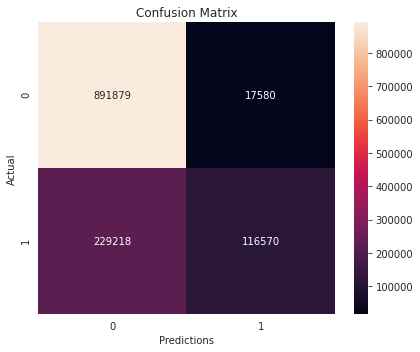

In [66]:
utils.show_confu_matri(x_full_predi_data, predi, cutof)#, 'stell_radiu', 5)

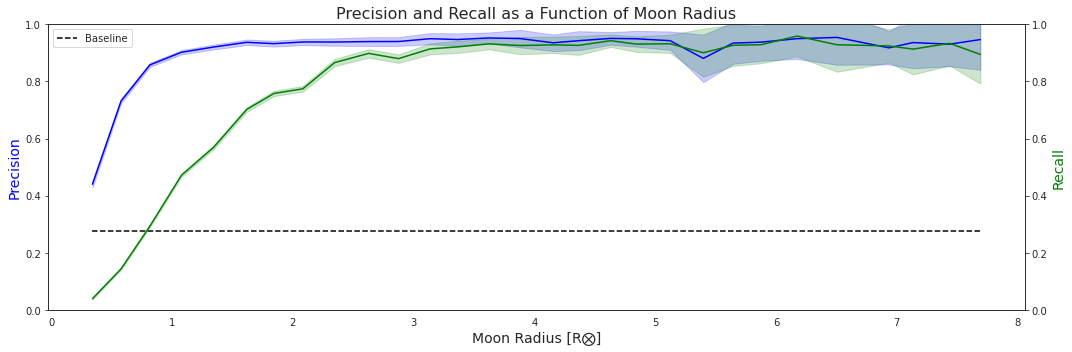

In [115]:
utils.show_featu_preci_recal(x_full_predi_data,
                       predi,
                       y_predi_data,
                       cutof,
                       featu='moon_radiu',
                       bins=30,
                       equal_width_bins=True,
                       stand_axis=True)
# Possible third axis with AUC
# AUC in red overplotted

/home/rfradkin/xom/py_script/utils.py:395: RuntimeWarning: invalid value encountered in double_scalars
  pr.append([tp / (tp + fp), fp / (tn + fp)])


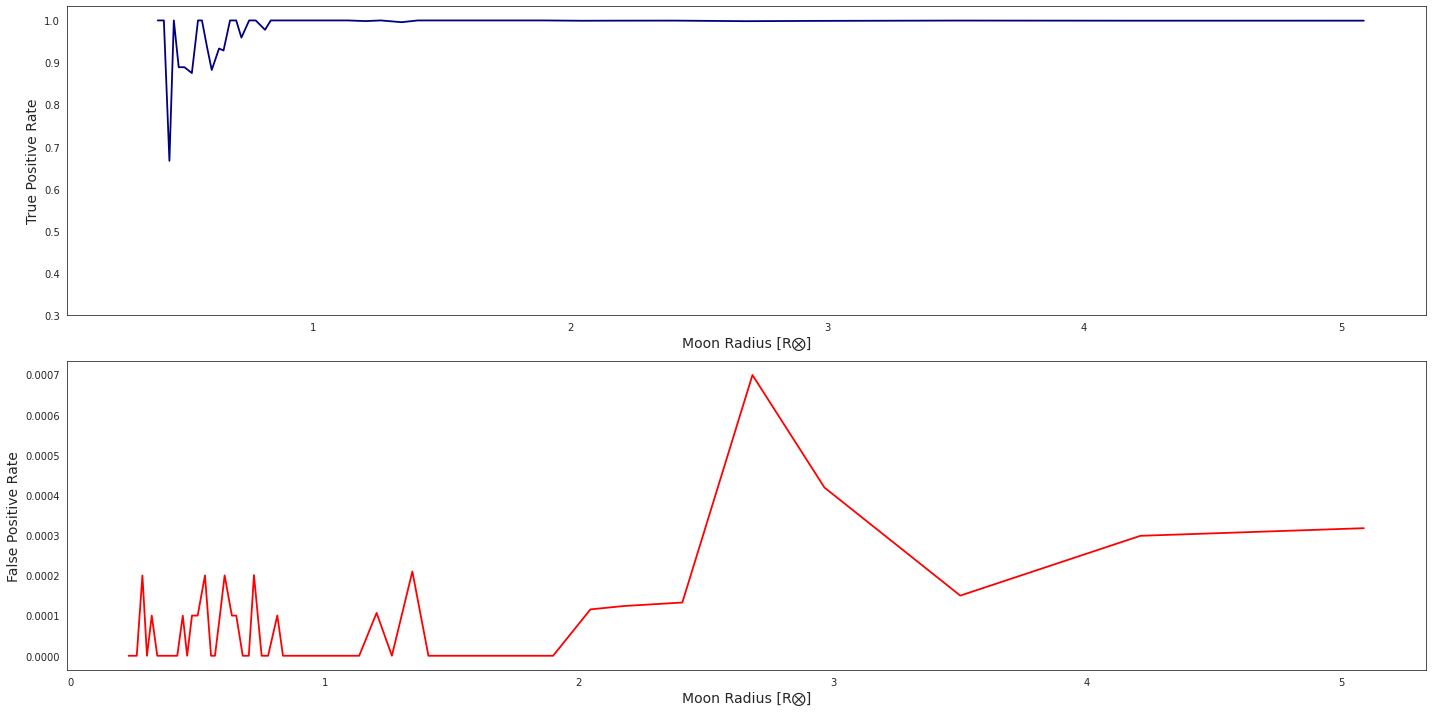

In [32]:
utils.show_tpr_fpr(x_full_predi_data, predi, cutof, 'moon_radiu', 50, False)

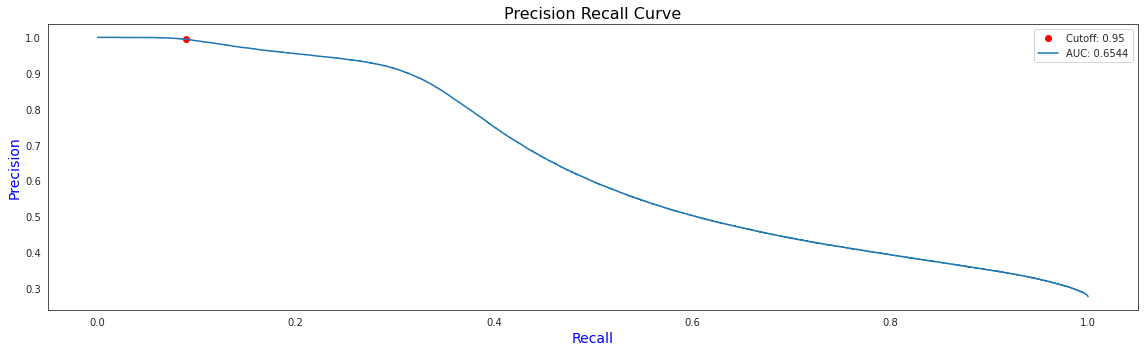

In [30]:
utils.show_preci_recal(predi, y_predi_data, cutof)

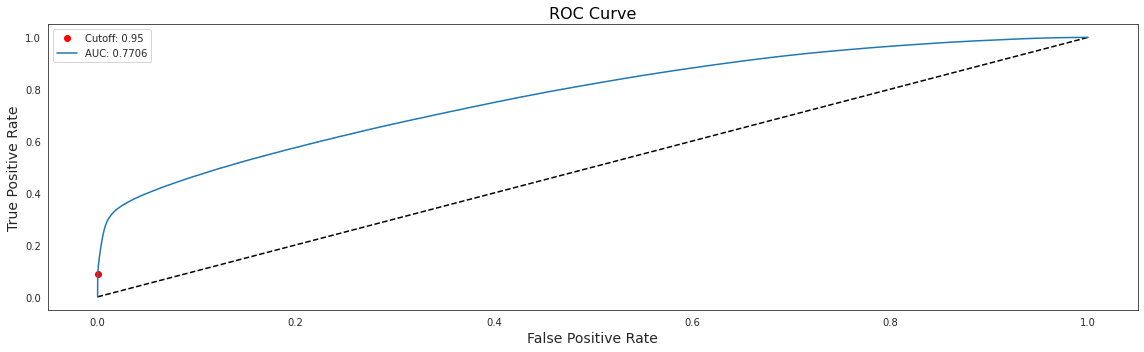

In [31]:
utils.show_roc(predi, y_predi_data, cutof)

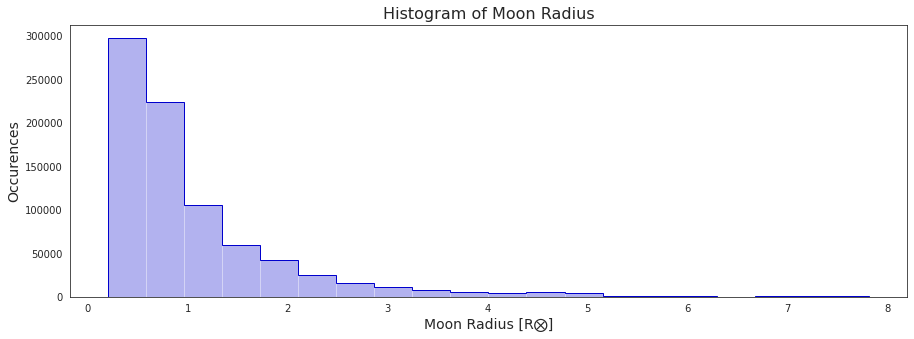

In [29]:
utils.show_histo(norma_full_x_data, 'moon_radiu')

#### Formatting